# Task 1: Exploratory Data Analysis & Preprocessing
## Intelligent Complaint Analysis for Financial Services

**Objective**  
Understand the structure, quality, and distribution of CFPB complaint data and prepare a clean dataset for downstream Retrieval-Augmented Generation (RAG).

**Outputs**
- Exploratory insights on complaint narratives
- Filtered dataset for selected financial products
- Cleaned complaint narratives saved for embedding


In [11]:
import sys
import os
from pathlib import Path

# FIX: Add project root to sys.path so 'src' can be imported
root_path = Path(os.getcwd()).parent
if str(root_path) not in sys.path:
    sys.path.append(str(root_path))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from src.config import RAW_DATA_DIR, PROCESSED_DATA_DIR
from src.utils.logging import get_logger

logger = get_logger(__name__)

pd.set_option("display.max_colwidth", 200)
sns.set(style="whitegrid")

In [12]:
# Verify filename in data/raw matches exactly
file_path = RAW_DATA_DIR / "cfpb_complaints.csv"

df = pd.read_csv(file_path, low_memory=False)
logger.info(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns")

df.head()

2026-01-04 14:14:08,900 | INFO | Dataset loaded with 9609797 rows and 18 columns


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer reports,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in the complaint,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer reports,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer reports,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer reports,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692


In [13]:
df.info()
print(f"\nColumns available: {df.columns.tolist()}")
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9609797 entries, 0 to 9609796
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 1.3+

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

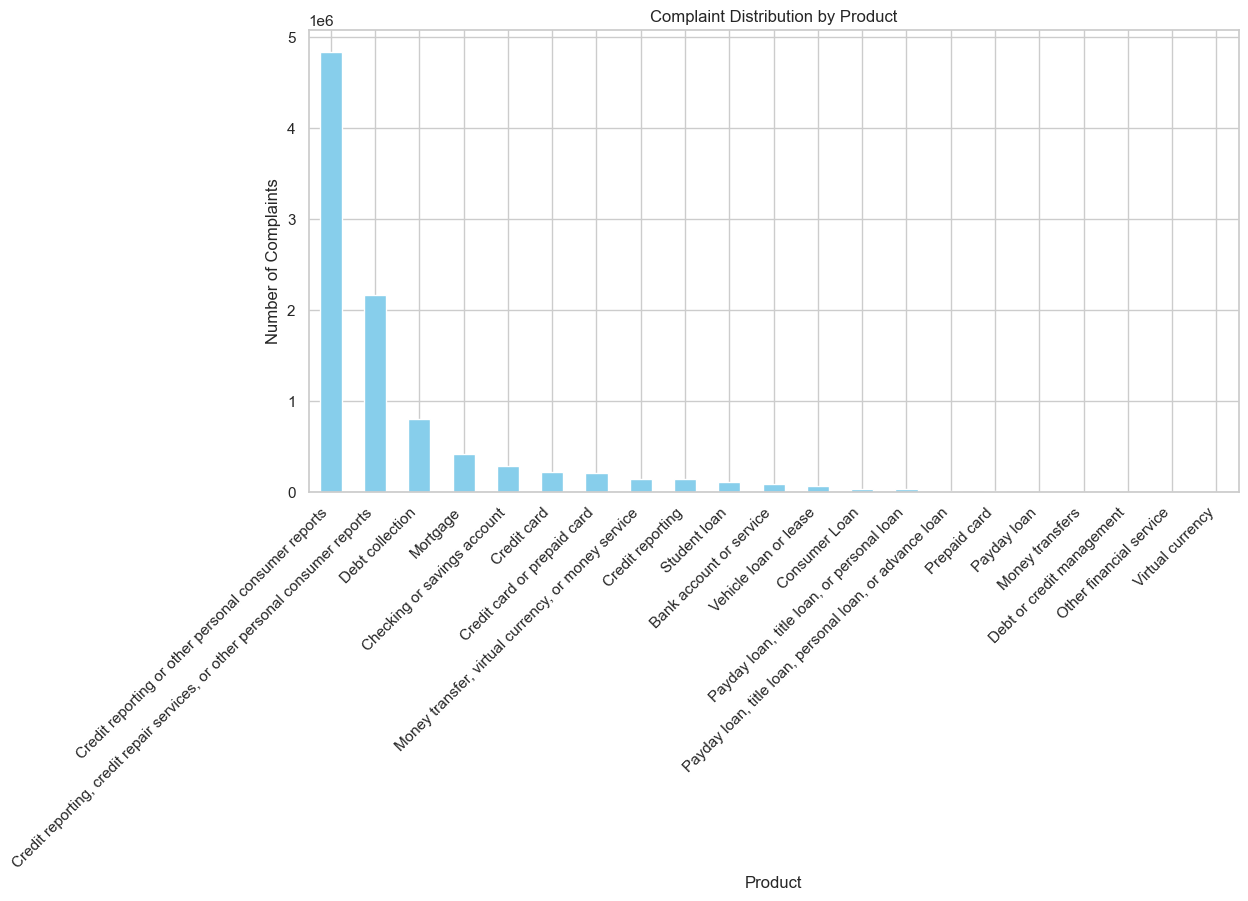

In [14]:
plt.figure(figsize=(12, 6))
df["Product"].value_counts().plot(kind="bar", color='skyblue')
plt.title("Complaint Distribution by Product")
plt.xlabel("Product")
plt.ylabel("Number of Complaints")
plt.xticks(rotation=45, ha='right')
plt.show()


In [15]:
n_total = len(df)
n_missing = df["Consumer complaint narrative"].isna().sum()

print(f"Total complaints: {n_total}")
print(f"Complaints without narrative: {n_missing}")
print(f"Percentage missing narratives: {n_missing / n_total:.2%}")

Total complaints: 9609797
Complaints without narrative: 6629041
Percentage missing narratives: 68.98%


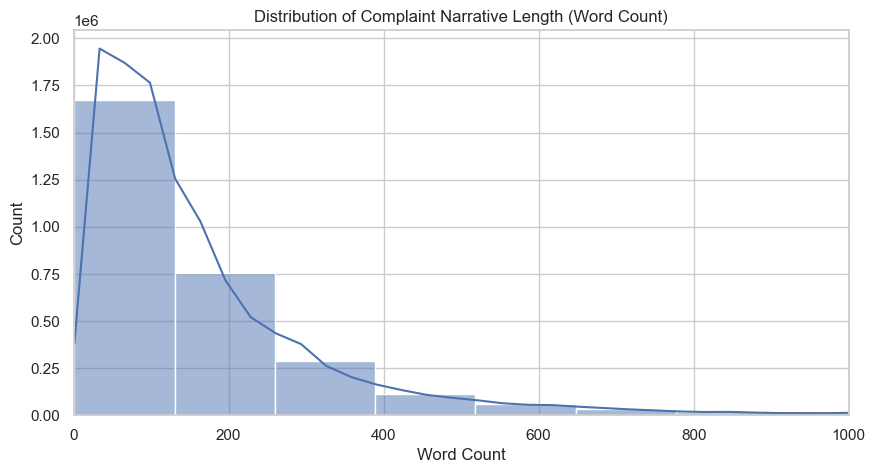

In [16]:
# Length in words for non-null narratives
df["narrative_length"] = df["Consumer complaint narrative"].fillna("").apply(
    lambda x: len(x.split())
)

plt.figure(figsize=(10, 5))
sns.histplot(df[df["narrative_length"] > 0]["narrative_length"], bins=50, kde=True)
plt.title("Distribution of Complaint Narrative Length (Word Count)")
plt.xlabel("Word Count")
plt.xlim(0, 1000) # Focusing on the bulk of data
plt.show()

In [17]:
TARGET_PRODUCTS = [
    "Credit card",
    "Personal loan",
    "Savings account",
    "Money transfer"
]

df_filtered = df[df["Product"].isin(TARGET_PRODUCTS)].copy()
logger.info(f"Rows after product filtering: {len(df_filtered)}")

2026-01-04 14:18:42,068 | INFO | Rows after product filtering: 226686


In [18]:
before = len(df_filtered)
df_filtered = df_filtered.dropna(subset=["Consumer complaint narrative"])
after = len(df_filtered)

logger.info(f"Dropped {before - after} rows without narratives. Remaining: {after}")

2026-01-04 14:19:19,263 | INFO | Dropped 146019 rows without narratives. Remaining: 80667


In [19]:
def clean_text(text: str) -> str:
    # Convert to string and lowercase
    text = str(text).lower()
    # Remove special characters and XXXX masking
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [20]:
df_filtered["clean_narrative"] = df_filtered["Consumer complaint narrative"].apply(clean_text)
display(df_filtered[["Consumer complaint narrative", "clean_narrative"]].head(3))

,Consumer complaint narrative,clean_narrative
12237,A XXXX XXXX card was opened under my name by a fraudster. I received a notice from XXXX that an account was just opened under my name. I reached out to XXXX XXXX to state that this activity was u...,a xxxx xxxx card was opened under my name by a fraudster i received a notice from xxxx that an account was just opened under my name i reached out to xxxx xxxx to state that this activity was unau...
13280,"Dear CFPB, I have a secured credit card with citibank which is changed to unsecured card and I have been calling n waitting for the check release the secured amount {$2500.00} for rhat credit card...",dear cfpb i have a secured credit card with citibank which is changed to unsecured card and i have been calling n waitting for the check release the secured amount 2500 00 for rhat credit card the...
13506,"I have a Citi rewards cards. The credit balance issued to me was {$8400.00}. I recently moved, which meant my bills would be lowered, which meant I'd have LESS use for my credit cards. So in order...",i have a citi rewards cards the credit balance issued to me was 8400 00 i recently moved which meant my bills would be lowered which meant i d have less use for my credit cards so in order to keep...


In [21]:
print(f"Final dataset shape: {df_filtered.shape}")
df_filtered[["Product", "Issue", "Company", "clean_narrative"]].sample(5)


Final dataset shape: (80667, 20)


,Product,Issue,Company,clean_narrative
2083929,Credit card,Problem with a purchase shown on your statement,JPMORGAN CHASE & CO.,i filed two disputes for the amount listed below and chases response contained false information on both of their responses i am attaching the documentation demonstrating that chase wrote charge f...
7950448,Credit card,Problem with a company's investigation into an existing problem,"EQUIFAX, INC.",please update my account and remove the inaccurate late payment i have always paid on time and never missed a payment this is causing me a lot of stress and xxxx and i can t even sleep properly be...
752328,Credit card,Problem with a purchase shown on your statement,DISCOVER BANK,on xx xx year i disputed a charge of 980 00 on my discover credit card related to a scam for which i made a police report and a complaint to xxxx on xx xx year i logged onto discover and saw that ...
5268069,Credit card,Billing disputes,JPMORGAN CHASE & CO.,we were charged 170 00 for a ride from the airport that we did not agree to the driver claimed to be an xxxx and was not no receipt provided we asked 2 3x how much the ride would be and he said do...
4691851,Credit card,"Other features, terms, or problems","CITIBANK, N.A.",citibank use xxxx xxxx words terms with me on the phone calling me brown etc they refused to investigate the credit card fraud reported last month with xxxx xxxx xxxx xxxx xxxx xxxx xxxxxx xx xxxx...


In [22]:
df_filtered.shape


(80667, 20)

In [23]:
output_path = PROCESSED_DATA_DIR / "filtered_complaints.csv"
df_filtered.to_csv(output_path, index=False)
logger.info(f"SUCCESS: Filtered dataset saved to {output_path}")

2026-01-04 14:22:41,822 | INFO | SUCCESS: Filtered dataset saved to C:\Users\hp\rag-complaint-chatbot\data\processed\filtered_complaints.csv


## Key Findings from EDA

1. Complaint volume is unevenly distributed across products, with credit-related products receiving the highest number of complaints.
2. A significant portion of records lack complaint narratives and were removed, as they provide no usable semantic information.
3. Narrative lengths vary widely, from very short descriptions to long, detailed explanations—confirming the need for text chunking before embedding.
4. After filtering to the four target products and removing empty narratives, we obtained a clean, high-quality dataset suitable for semantic search and RAG-based analysis.
